# Principal Components

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/cwatm_azure_with_static_1990_2000_2107_090332"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = data_dir
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

In [4]:
# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 669/669 [00:00<00:00, 1852.84it/s]


Using the model weights from /datadrive/data/runs/cwatm_azure_with_static_1990_2000_2107_090332/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(24, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [5]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

# Create the cell states

In [8]:
from scripts.cell_state.utils import (
    read_basin_list, 
    get_train_test_cell_states, 
    normalize_and_convert_dimension_to_variable_for_cell_state_data, 
    create_train_test_default_dict_for_all_target_vars, 
    train_and_evaluate_models
)

In [9]:
TARGET = "ERA5"
PER_BASIN = False

## Get training/test dataset

In [12]:
train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

out_of_sample = not all(np.isin(test_sids, train_sids))
print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

Out of Sample: False


## Probe the basins

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_cn, test_cn = get_train_test_cell_states(run_dir, cfg)

# Calculate PCA in numpy (flexibility)
- [Article here](http://ethen8181.github.io/machine-learning/dim_reduct/PCA.html)
- [SO Discussion = Dinner Table Explanation](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
- "eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude (variance explained along the principal components)."

```
class PCAModel:
    """
    Principal component analysis (PCA)
    
    Parameters
    ----------
    n_components : int
        top number of principal components to keep
    """

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # standardize
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X = (X - self.mean) / self.scale
        
        # eigendecomposition
        eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T))
        self.components = eig_vecs[:, :self.n_components]
        var_exp = eig_vals / np.sum(eig_vals)
        self.explained_variance_ratio = var_exp[:self.n_components]
        return self

    def transform(self, X):
        X = X.copy()
        X = (X - self.mean) / self.scale
        X_pca = X @ self.components
        return X_pca

```

In [36]:
# standardize the vector (zero mean, unit variance)
global_mean = True
per_time = False

epsilon = 1e-10

X = test_cn["c_n"].dropna(dim="date", how="all").values
station_ids = test_cn["c_n"].dropna(dim="date", how="all").station_id.values

if global_mean:
    #  divide by the GLOBAL dimension-mean (collapse space and time)
    X_norm = (X - X.mean(axis=(0, 1))) / X.std(axis=(0, 1))
else:
    #  divide by basin-specific dimension mean (collapse time only)
    X_norm = (X - X.mean(axis=(0))) / (X.std(axis=(0)) + epsilon)
    
X_norm.shape

(3652, 669, 64)

In [37]:
# Covariance matrix = (difference from mean)^2 / number of spatial points
# difference of each point from the mean
vec_mean = np.mean(X_norm, axis=0)
vec_diff = X_norm - vec_mean

# shape = (time, dimensions, dimensions)
cov_mat = np.einsum(
    "nsv,nsw->nvw" if per_time else "nsv,nsw->vw", 
    vec_diff, vec_diff
) / (X_norm.shape[1] - 1)
cov_mat.shape

(64, 64)

In [38]:
# eigendecomposition 
eig_vals, eig_vecs = np.linalg.eig(cov_mat if not per_time else cov_mat[0, :, :])

In [39]:
# sorting the eigenpairs
# eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data
eig_vals_total = np.sum(eig_vals, axis=0)
var_exp = eig_vals / eig_vals_total
cum_var_exp = np.cumsum(var_exp, axis=0)
# var_exp[np.argsort(var_exp, axis=1)]

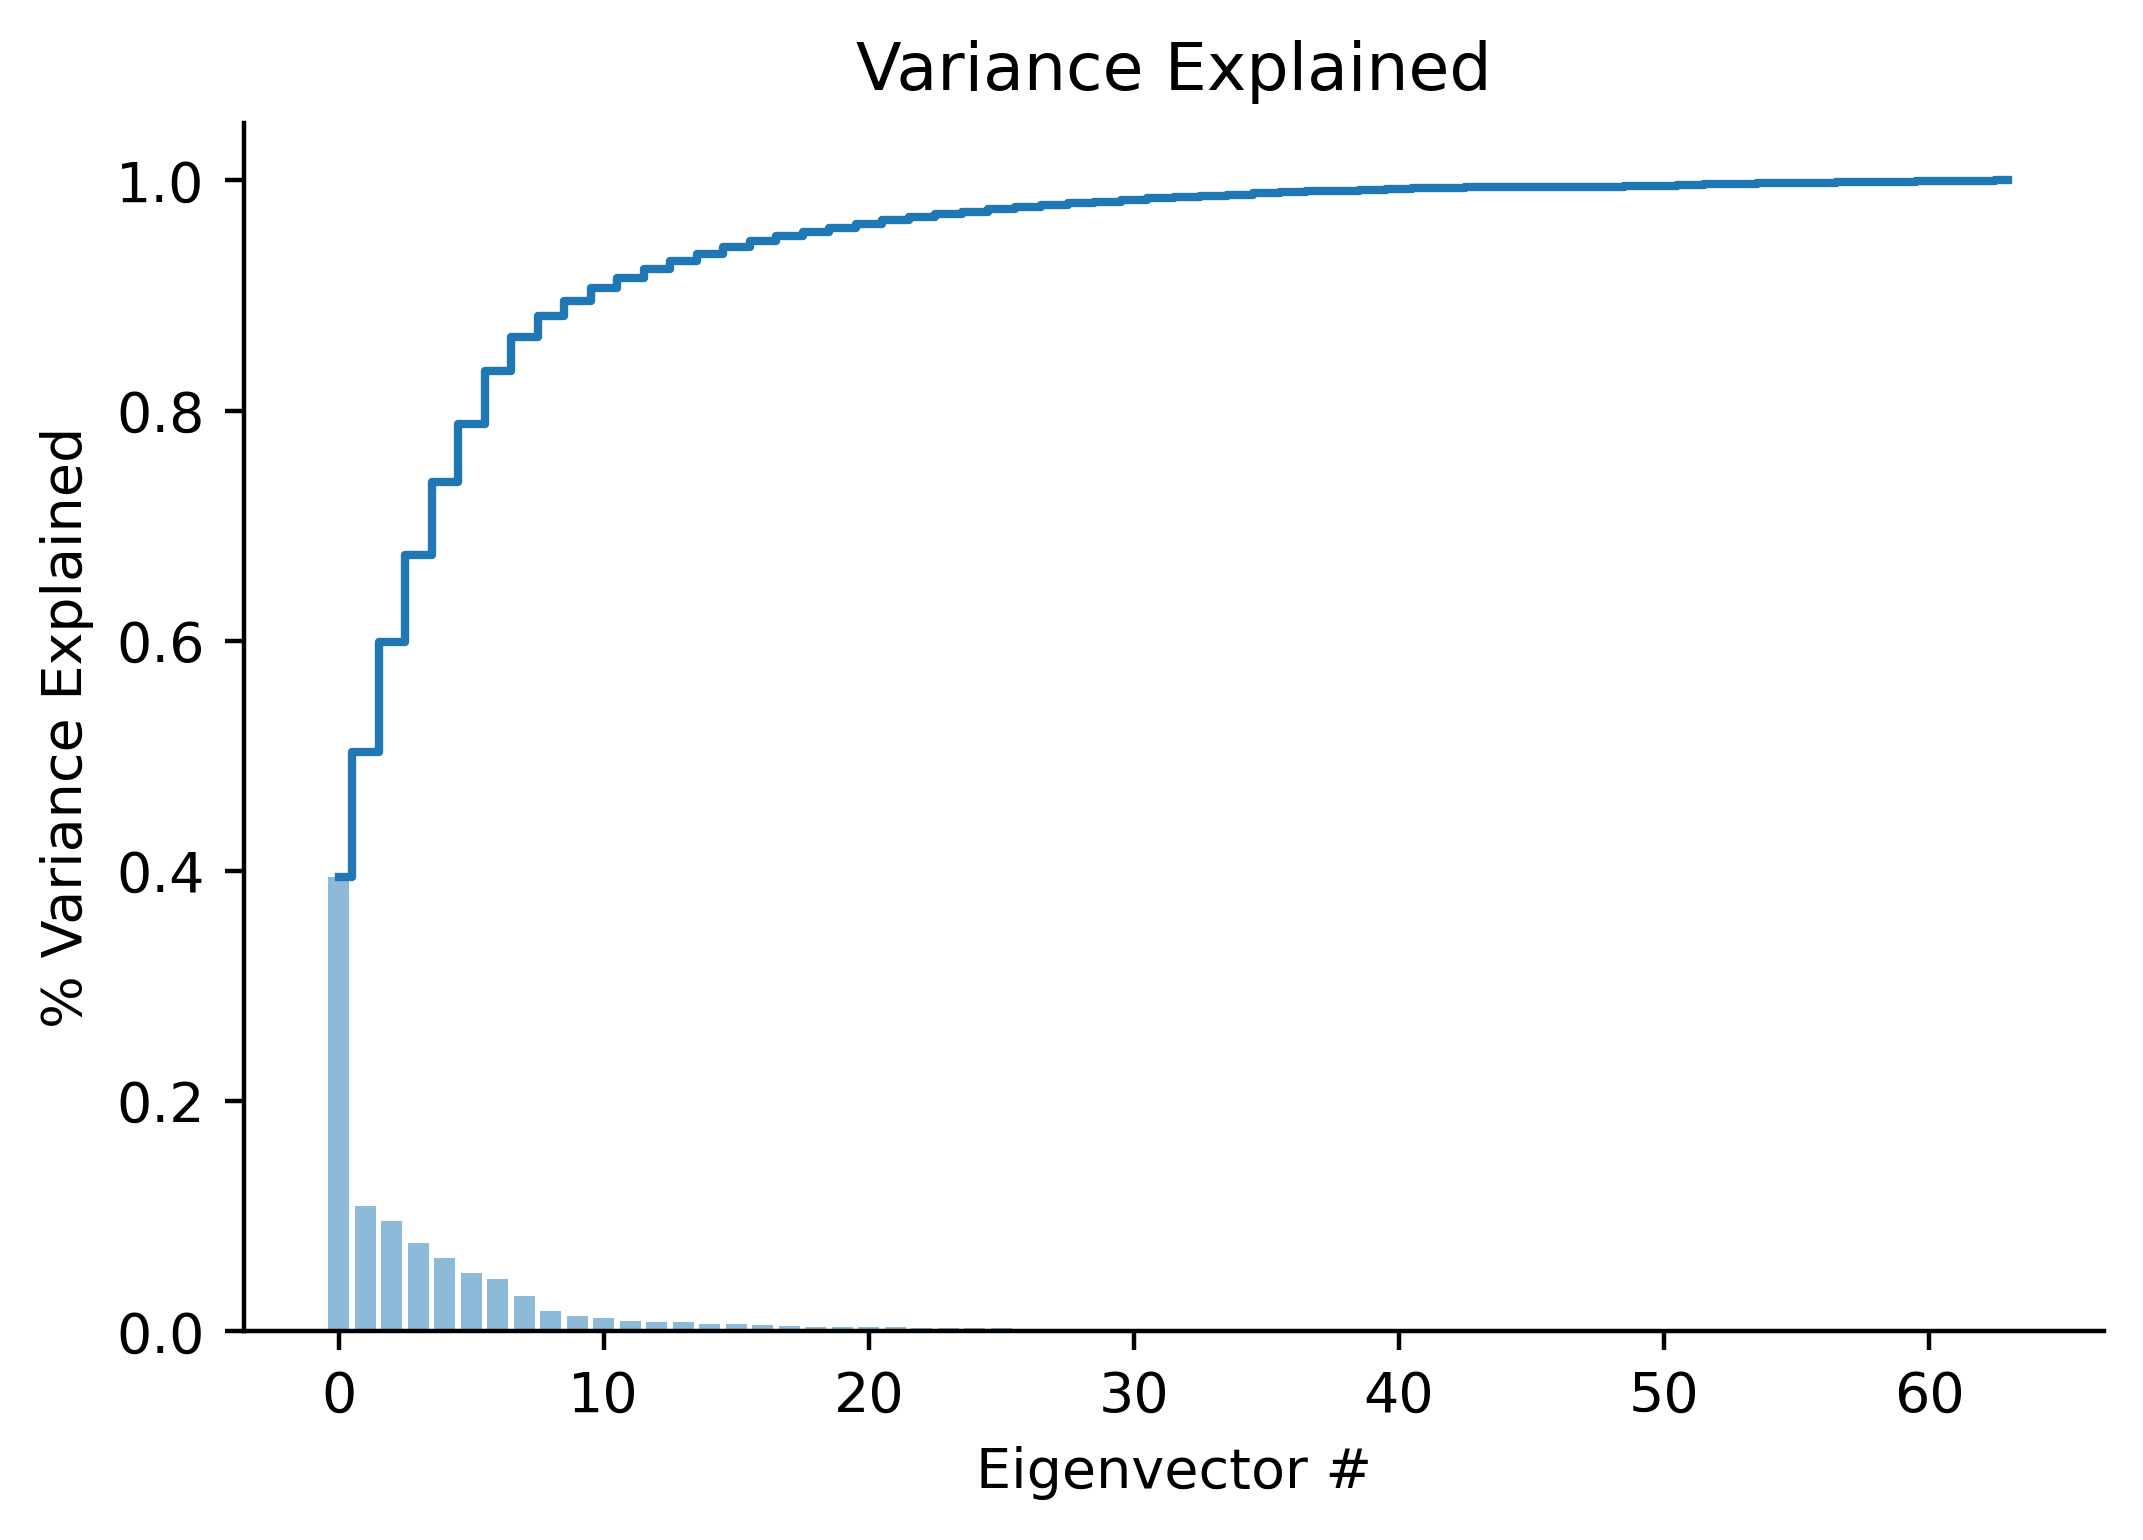

In [40]:
var_exp_ = var_exp
cum_var_exp_ =  cum_var_exp

with plt.rc_context({"figure.dpi": 400}):
    plt.bar(range(var_exp_.shape[0]), var_exp_, alpha = 0.5, 
            align = 'center', label = 'individual explained variance')
    plt.step(range(var_exp_.shape[0]), cum_var_exp_, 
             where = 'mid', label = 'cumulative explained variance')

    ax = plt.gca()
    ax.set_title("Variance Explained")
    ax.set_xlabel("Eigenvector #")
    ax.set_ylabel("% Variance Explained")
    sns.despine()

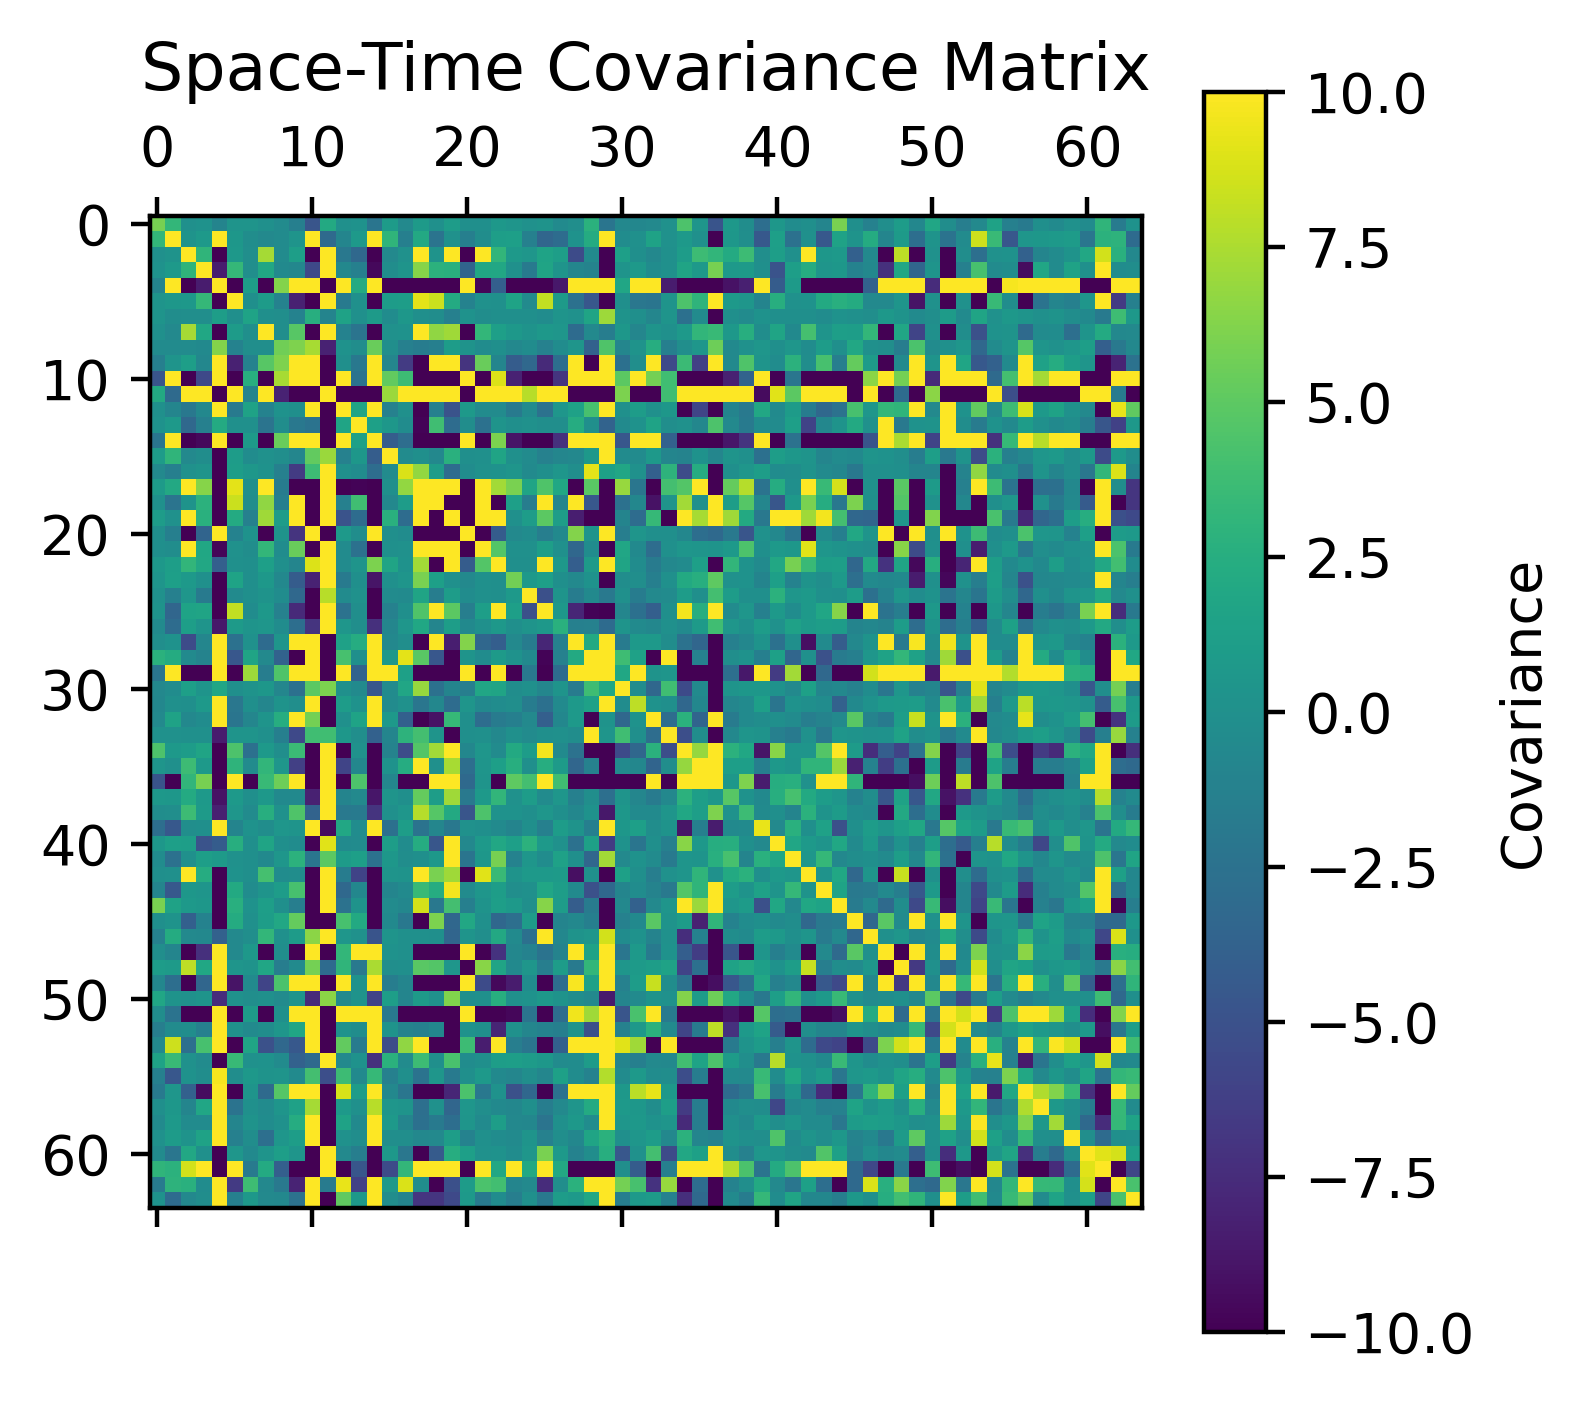

In [41]:
with plt.rc_context({"figure.dpi": 400}):
    im = plt.matshow(cov_mat[0, :, :] if per_time else cov_mat, vmin=-10, vmax=10)  # , vmin=-10, vmax=10
    plt.colorbar(im, label="Covariance")
    ax = plt.gca()
    ax.set_title("Space-Time Covariance Matrix")

In [42]:
X_norm.shape

(3652, 669, 64)

In [43]:
# Get top 2 eigenvectors
# n=n_times, s=stations, c=cell_states, e=eigenvectors
# out: (stations, eigenvec #)
X_norm_pca = np.einsum("nsc,ce->se", X_norm, eig_vecs[:, :2])
X_norm_pca.shape

(669, 2)

<ipython-input-44-f7131d3006d1>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])


[]

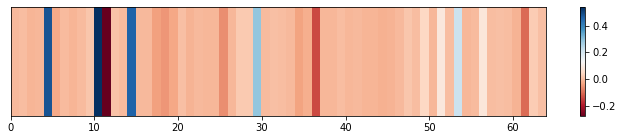

In [44]:
# which dimensions in the largest eigenvector?
f, ax = plt.subplots(figsize=(12, 2))
m = ax.pcolormesh(eig_vecs[:, 0].reshape(1, -1), cmap="RdBu")
plt.colorbar(m)
ax = plt.gca()
ax.set_yticklabels([""])
ax.set_yticks([])

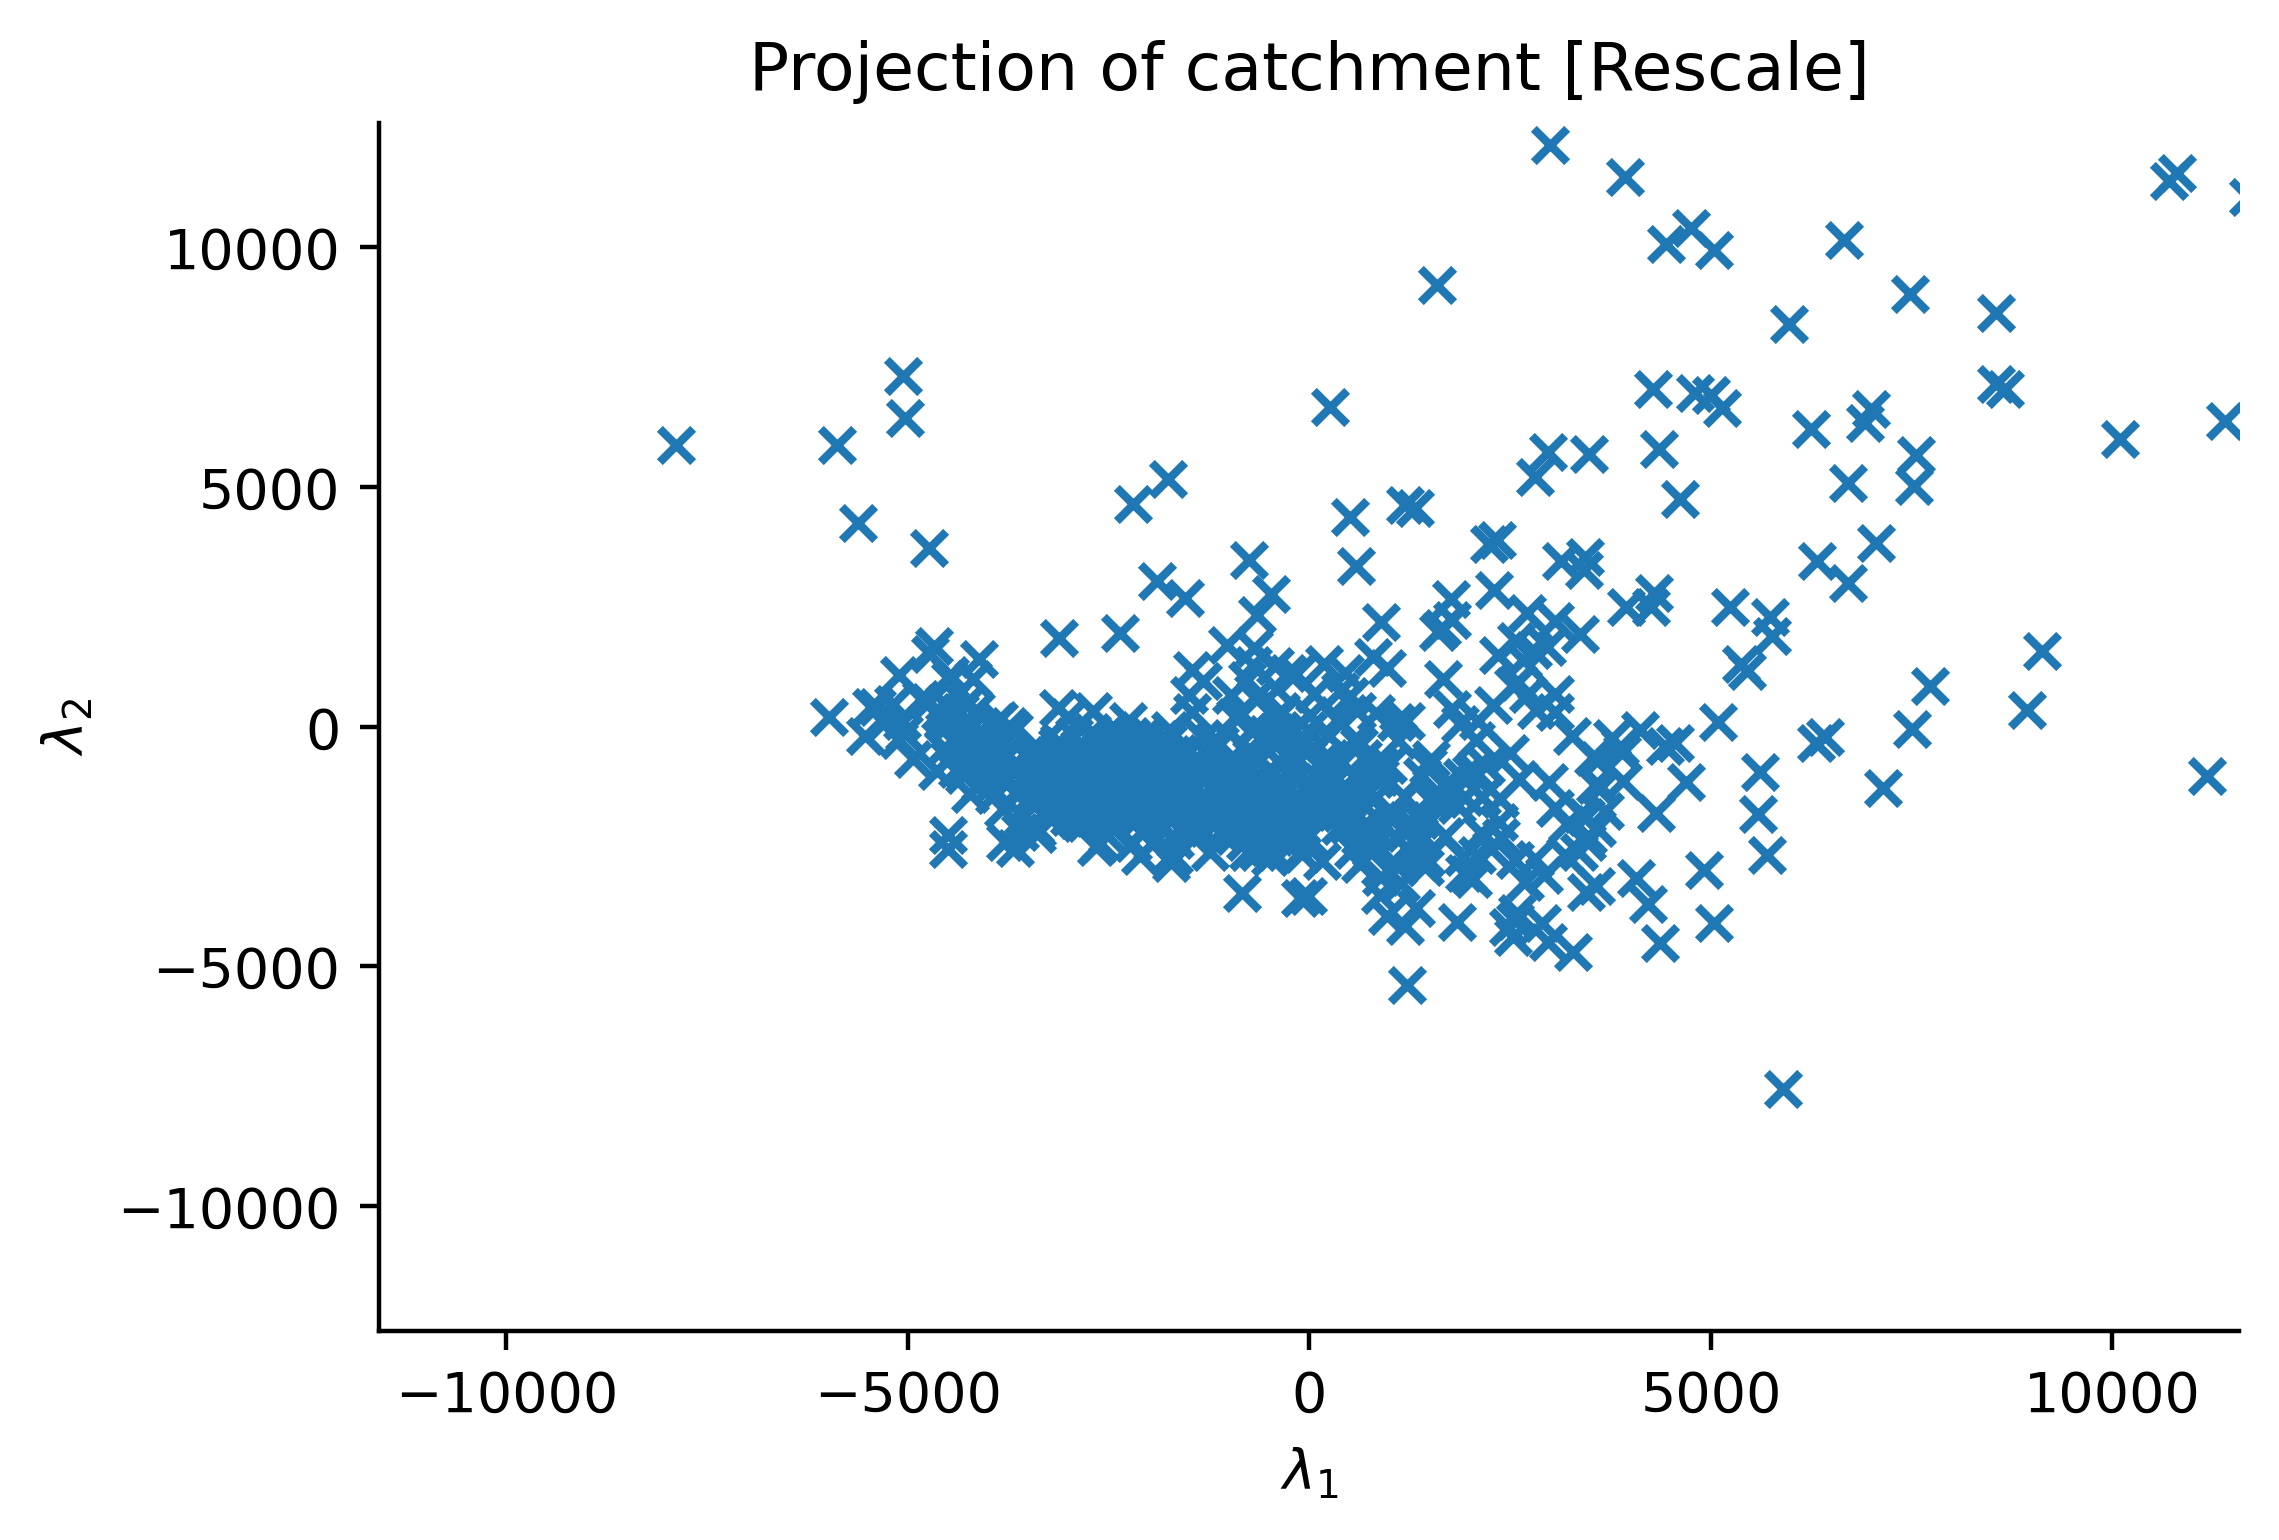

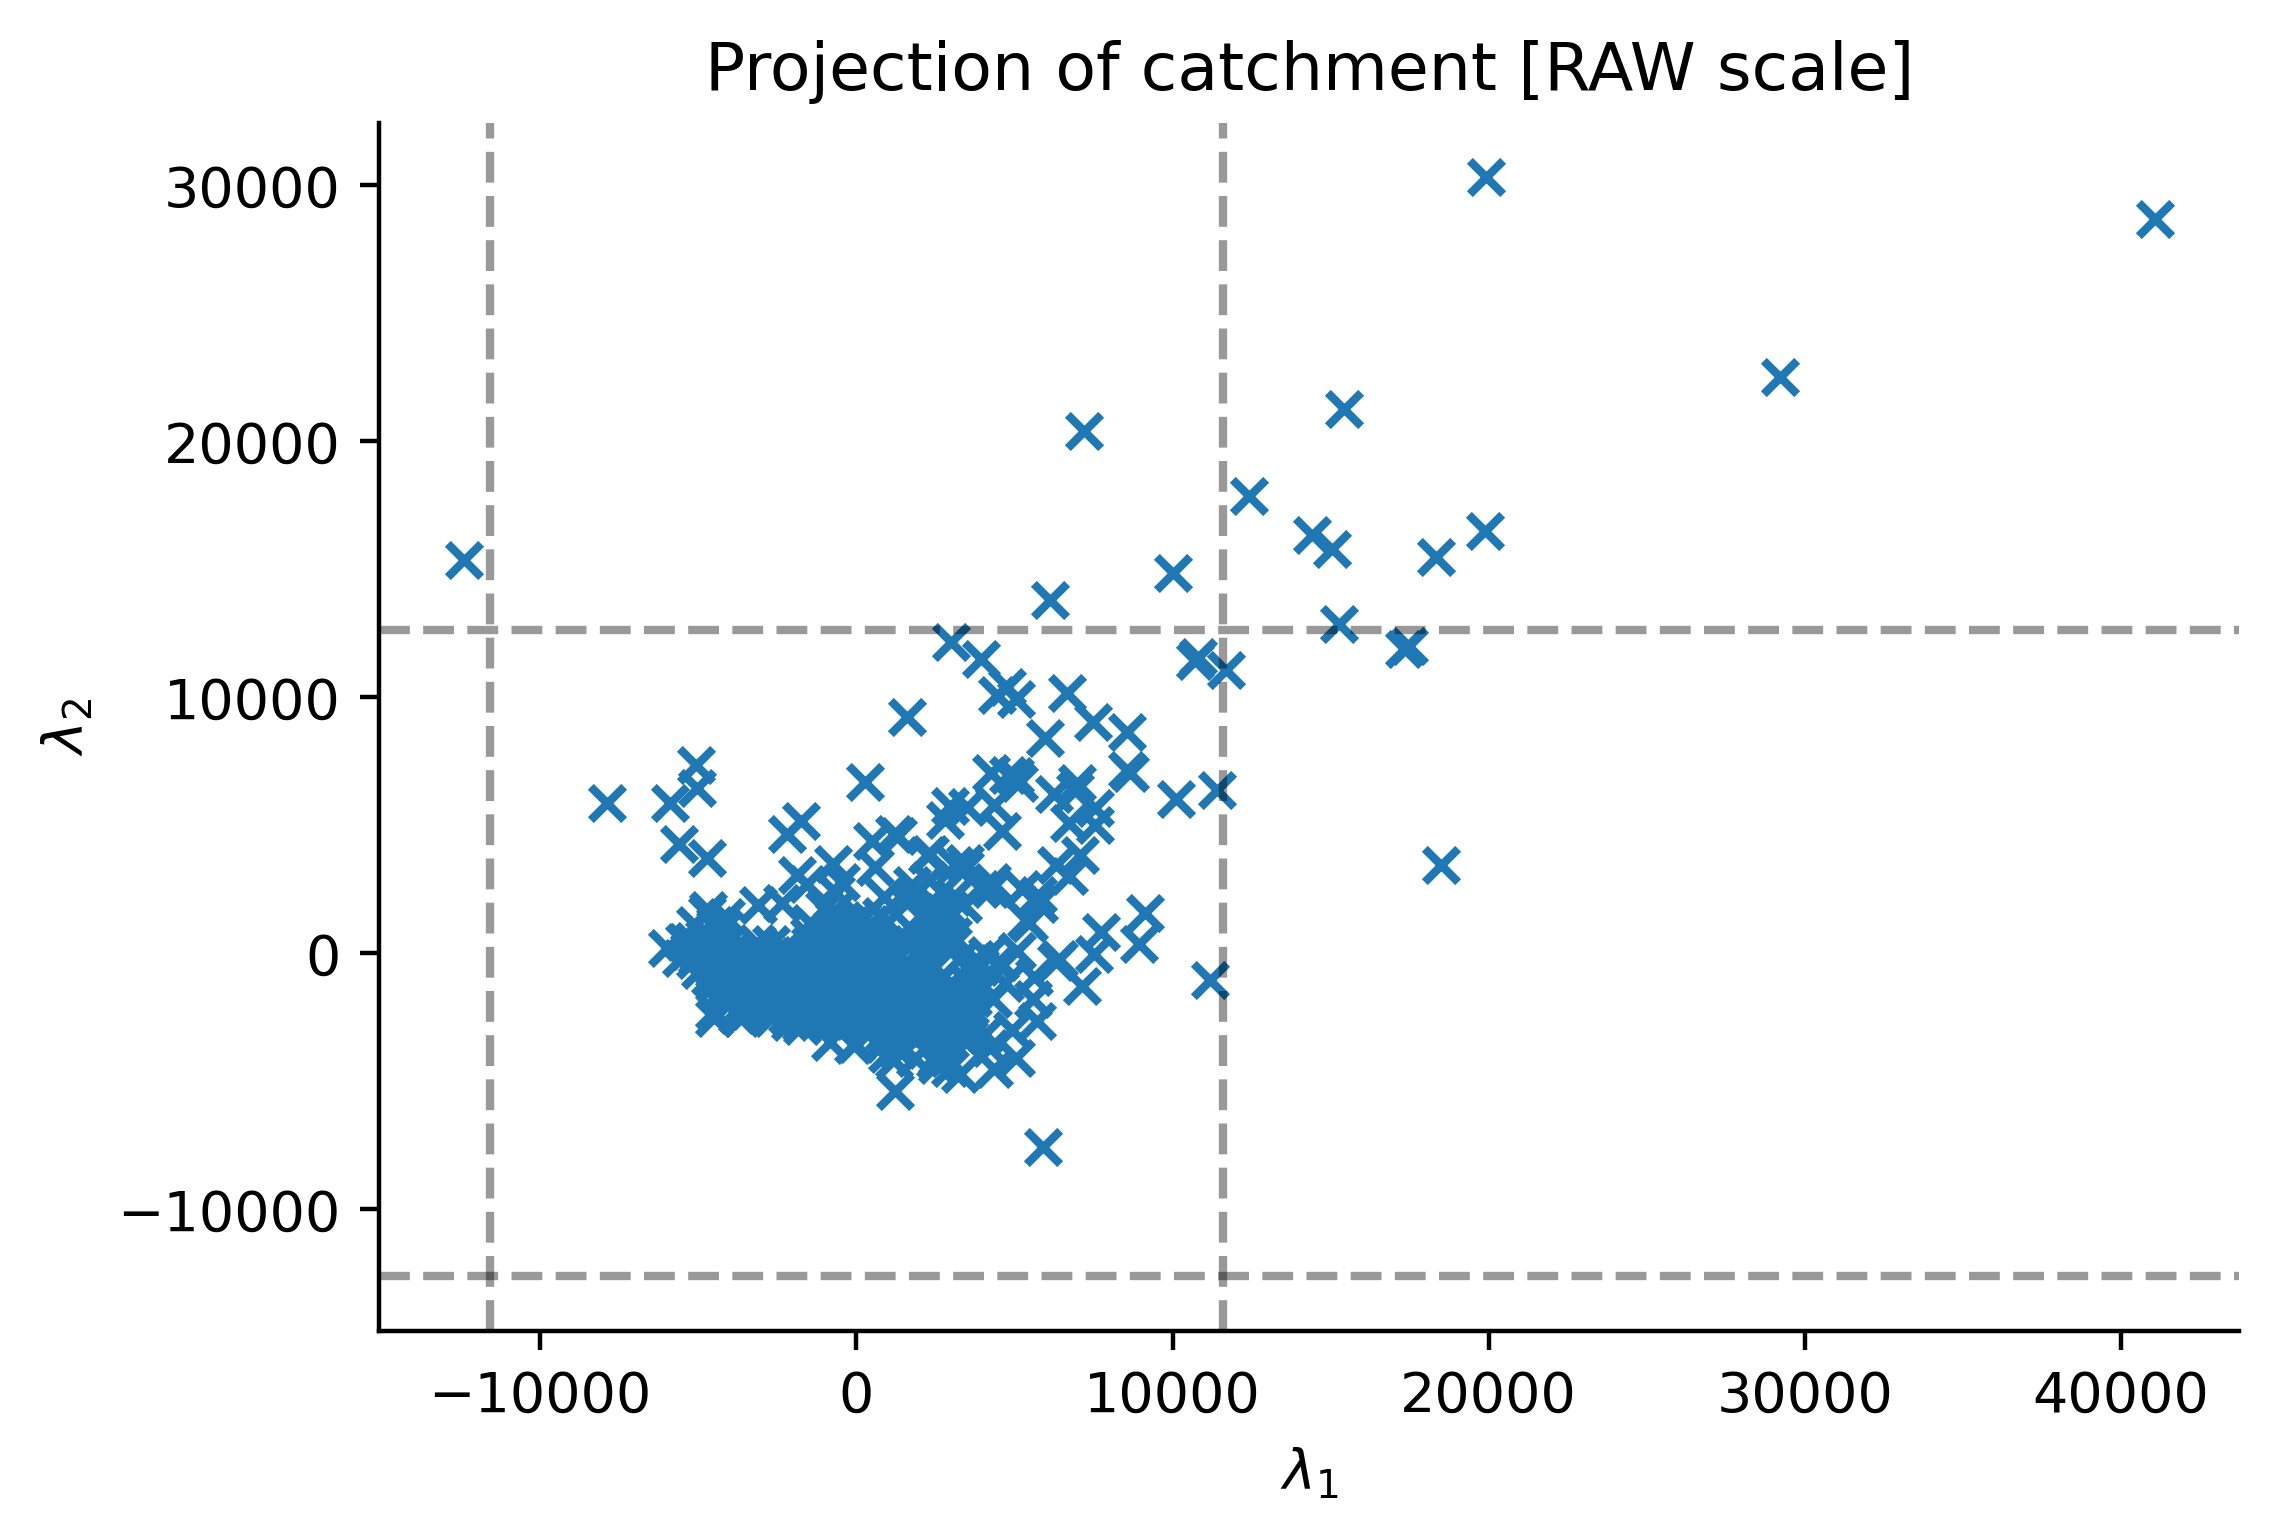

In [98]:
q = 0.02
xmax = max(abs(np.quantile(X_norm_pca[:, 0], q=1-q)), abs(np.quantile(X_norm_pca[:, 0], q=q)))
ymax = max(abs(np.quantile(X_norm_pca[:, 1], q=1-q)), abs(np.quantile(X_norm_pca[:, 1], q=q)))

# xmax = None
# ymax = None
with plt.rc_context({"figure.dpi": 400}):
    plt.scatter(X_norm_pca[:, 0], X_norm_pca[:, 1], marker="x")
    ax = plt.gca()
    ax.set_xlabel("$\lambda_1$")
    ax.set_ylabel("$\lambda_2$")
    ax.set_title("Projection of catchment [Rescale]")
    ax.set_xlim(-xmax if xmax is not None else None, xmax)
    ax.set_ylim(-ymax if xmax is not None else None, ymax)
    sns.despine()
    
    f, ax = plt.subplots()
    plt.scatter(X_norm_pca[:, 0], X_norm_pca[:, 1], marker="x")
    ax = plt.gca()
    ax.set_xlabel("$\lambda_1$")
    ax.set_ylabel("$\lambda_2$")
    ax.set_title("Projection of catchment [RAW scale]")
    ax.axhline(-ymax, ls="--", alpha=0.4, color="k")
    ax.axhline(ymax, ls="--", alpha=0.4, color="k")
    ax.axvline(-xmax, ls="--", alpha=0.4, color="k")
    ax.axvline(xmax, ls="--", alpha=0.4, color="k")
    sns.despine()

In [60]:
X_norm_pca.shape

(669, 2)

In [64]:
pca_ds = xr.Dataset(
    {"value": (("station_id", "PC"), X_norm_pca)},
    coords={"station_id": [int(sid) for sid in station_ids], "PC": np.arange(1, X_norm_pca.shape[-1] + 1)}
)

In [95]:
# defined bounds based on quantile extremes ()
pc1_bnds = (-xmax, xmax)
pc2_bnds = (-ymax, ymax)

# get the sids outside bounds
extreme_sids = np.unique(np.concatenate(
    [
        pca_ds.where((pca_ds.sel(PC=1) < pc1_bnds[0]) | (pca_ds.sel(PC=1) > pc1_bnds[-1]), drop=True).station_id.values,
        pca_ds.where((pca_ds.sel(PC=2) < pc2_bnds[0]) | (pca_ds.sel(PC=2) > pc2_bnds[-1]), drop=True).station_id.values
    ]
))

In [96]:
extreme_sids

array([ 6007, 12005, 15006, 21009, 23001, 27003, 28022, 33035, 39001,
       39072, 54057, 60010, 76007, 77002, 78003, 85004, 89007, 90003])

In [106]:
from scripts.geospatial import plot_spatial_location
from scripts.plots import plot_context

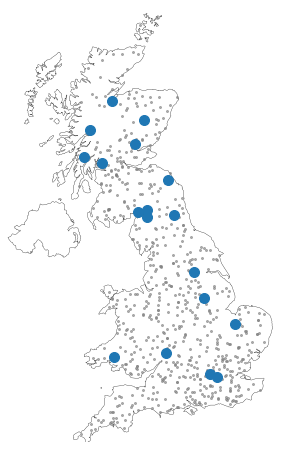

In [107]:
plot_spatial_location(extreme_sids, points)

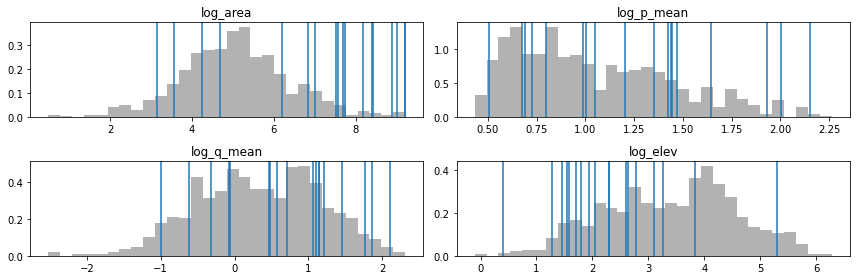

In [119]:
log_static = static.copy()
log_static["log_area"] = np.log(static["area"])
log_static["log_p_mean"] = np.log(static["p_mean"])
log_static["log_elev"] = np.log(static["gauge_elev"])
log_static["log_q_mean"] = np.log(static["q_mean"])

plot_context(static=log_static, sids=extreme_sids, variables=["log_area", "log_p_mean", "log_q_mean", "log_elev"]);

In [126]:
from scripts.cwatm_data.masked_mean_cwatm_data import save_basin_list_to_txt_file


# write txt file for basins except extremes and see what happens ...
all_sids = pca_ds['station_id'].values
subset_sids = all_sids[~np.isin(all_sids, extreme_sids)]
filepath = Path(".").home() / f"neuralhydrology/data/subset_stations.txt"
save_basin_list_to_txt_file(filepath, subset_sids)

In [ ]:
‘

In [ ]:
df = static[cfg.static_attributes].to_dataframe().loc[cn["c_n"].station_id.astype(int).values]
df["lambda_1"] = X_norm_pca[:, 0]
df["lambda_2"] = X_norm_pca[:, 1]

for col in df.columns:
    df[f"log_{col}"] = np.log(df[col])

In [ ]:
print(cfg.static_attributes)

In [ ]:
# plt.hist(df["log_area"], density=True)
# vmin = df["log_area"].quantile(q=0.15)
# vmax = df["log_area"].quantile(q=0.85)
# plt.gca().axvline(vmin)
# plt.gca().axvline(vmax)

axes_limit_quantiles = 0.1

# axes limits
xmax = max(
    abs(np.quantile(df["lambda_1"], q=1 - axes_limit_quantiles)), 
    abs(np.quantile(df["lambda_1"], q=axes_limit_quantiles))
)
ymax = max(
    abs(np.quantile(df["lambda_2"], q=1 - axes_limit_quantiles)), 
    abs(np.quantile(df["lambda_2"], q=axes_limit_quantiles))
)

vars_to_plot = ["log_area", "log_p_mean", "frac_snow", "crop_perc"]
with plt.rc_context({"figure.dpi": 400}):
    f, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=True, sharex=True, sharey=True)
    axes_limit_quantiles = 0.1
    
    for ix, var in enumerate(vars_to_plot):
        # cbar limits
        vmin = df[var].quantile(q=0.15)
        vmax = df[var].quantile(q=0.85)

        ax = axs[np.unravel_index(ix, (2, 2))]
        sc = ax.scatter(df["lambda_1"], df["lambda_2"], c=df[var], vmin=vmin, vmax=vmax, marker="x", alpha=0.6)
        plt.colorbar(sc, ax=ax, label=var)


        ax.set_xlim(-xmax, xmax)
        ax.set_ylim(-ymax, ymax)
        ax.set_xlabel("$\lambda_1$")
        ax.set_ylabel("$\lambda_2$")
        ax.set_title(var)
        sns.despine()

In [ ]:
# from scipy.interpolate import griddata

# # axes limits
# xmax = max(
#     abs(np.quantile(df["lambda_1"], q=1 - axes_limit_quantiles)), 
#     abs(np.quantile(df["lambda_1"], q=axes_limit_quantiles))
# )
# ymax = max(
#     abs(np.quantile(df["lambda_2"], q=1 - axes_limit_quantiles)), 
#     abs(np.quantile(df["lambda_2"], q=axes_limit_quantiles))
# )

# def grid(x, y, z, resX=100, resY=100):
#     "Convert 3 column data to matplotlib grid"
#     xi = np.linspace(min(x), max(x), resX)
#     yi = np.linspace(min(y), max(y), resY)
#     Z = griddata(x, y, z, xi, yi)
#     X, Y = np.meshgrid(xi, yi)
#     return X, Y, Z


# vars_to_plot = ["log_area", "log_p_mean", "frac_snow", "crop_perc"]
# with plt.rc_context({"figure.dpi": 400}):
#     f, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=True, sharex=True, sharey=True)
#     axes_limit_quantiles = 0.1
    
#     for ix, var in enumerate(vars_to_plot):
#         # cbar limits
#         vmin = df[var].quantile(q=0.15)
#         vmax = df[var].quantile(q=0.85)

#         ax = axs[np.unravel_index(ix, (2, 2))]
#         lambda_1, lambda_2, Z = grid(df["lambda_1"], df["lambda_2"], df[var].values.reshape(-1, 1))
        
#         sc = ax.contourf(lambda_1, lambda_2, c=df[var], vmin=vmin, vmax=vmax, alpha=0.6)
#         plt.colorbar(sc, ax=ax, label=var)


#         ax.set_xlim(-xmax, xmax)
#         ax.set_ylim(-ymax, ymax)
#         ax.set_xlabel("$\lambda_1$")
#         ax.set_ylabel("$\lambda_2$")
#         ax.set_title(var)
#         sns.despine()

In [ ]:
assert False

# Preprocess Input Data

In [128]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# New data
station_dim = "station_id"
time_dim = "date"

# normalize ???
mean_ = cn.mean(dim=[station_dim, time_dim])
std_ = cn.std(dim=[station_dim, time_dim])
norm_cs_data = (cn - mean_) / std_
# or per station-dimension
# norm_cs_data = 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

### What do the internal states of LSTM look like?

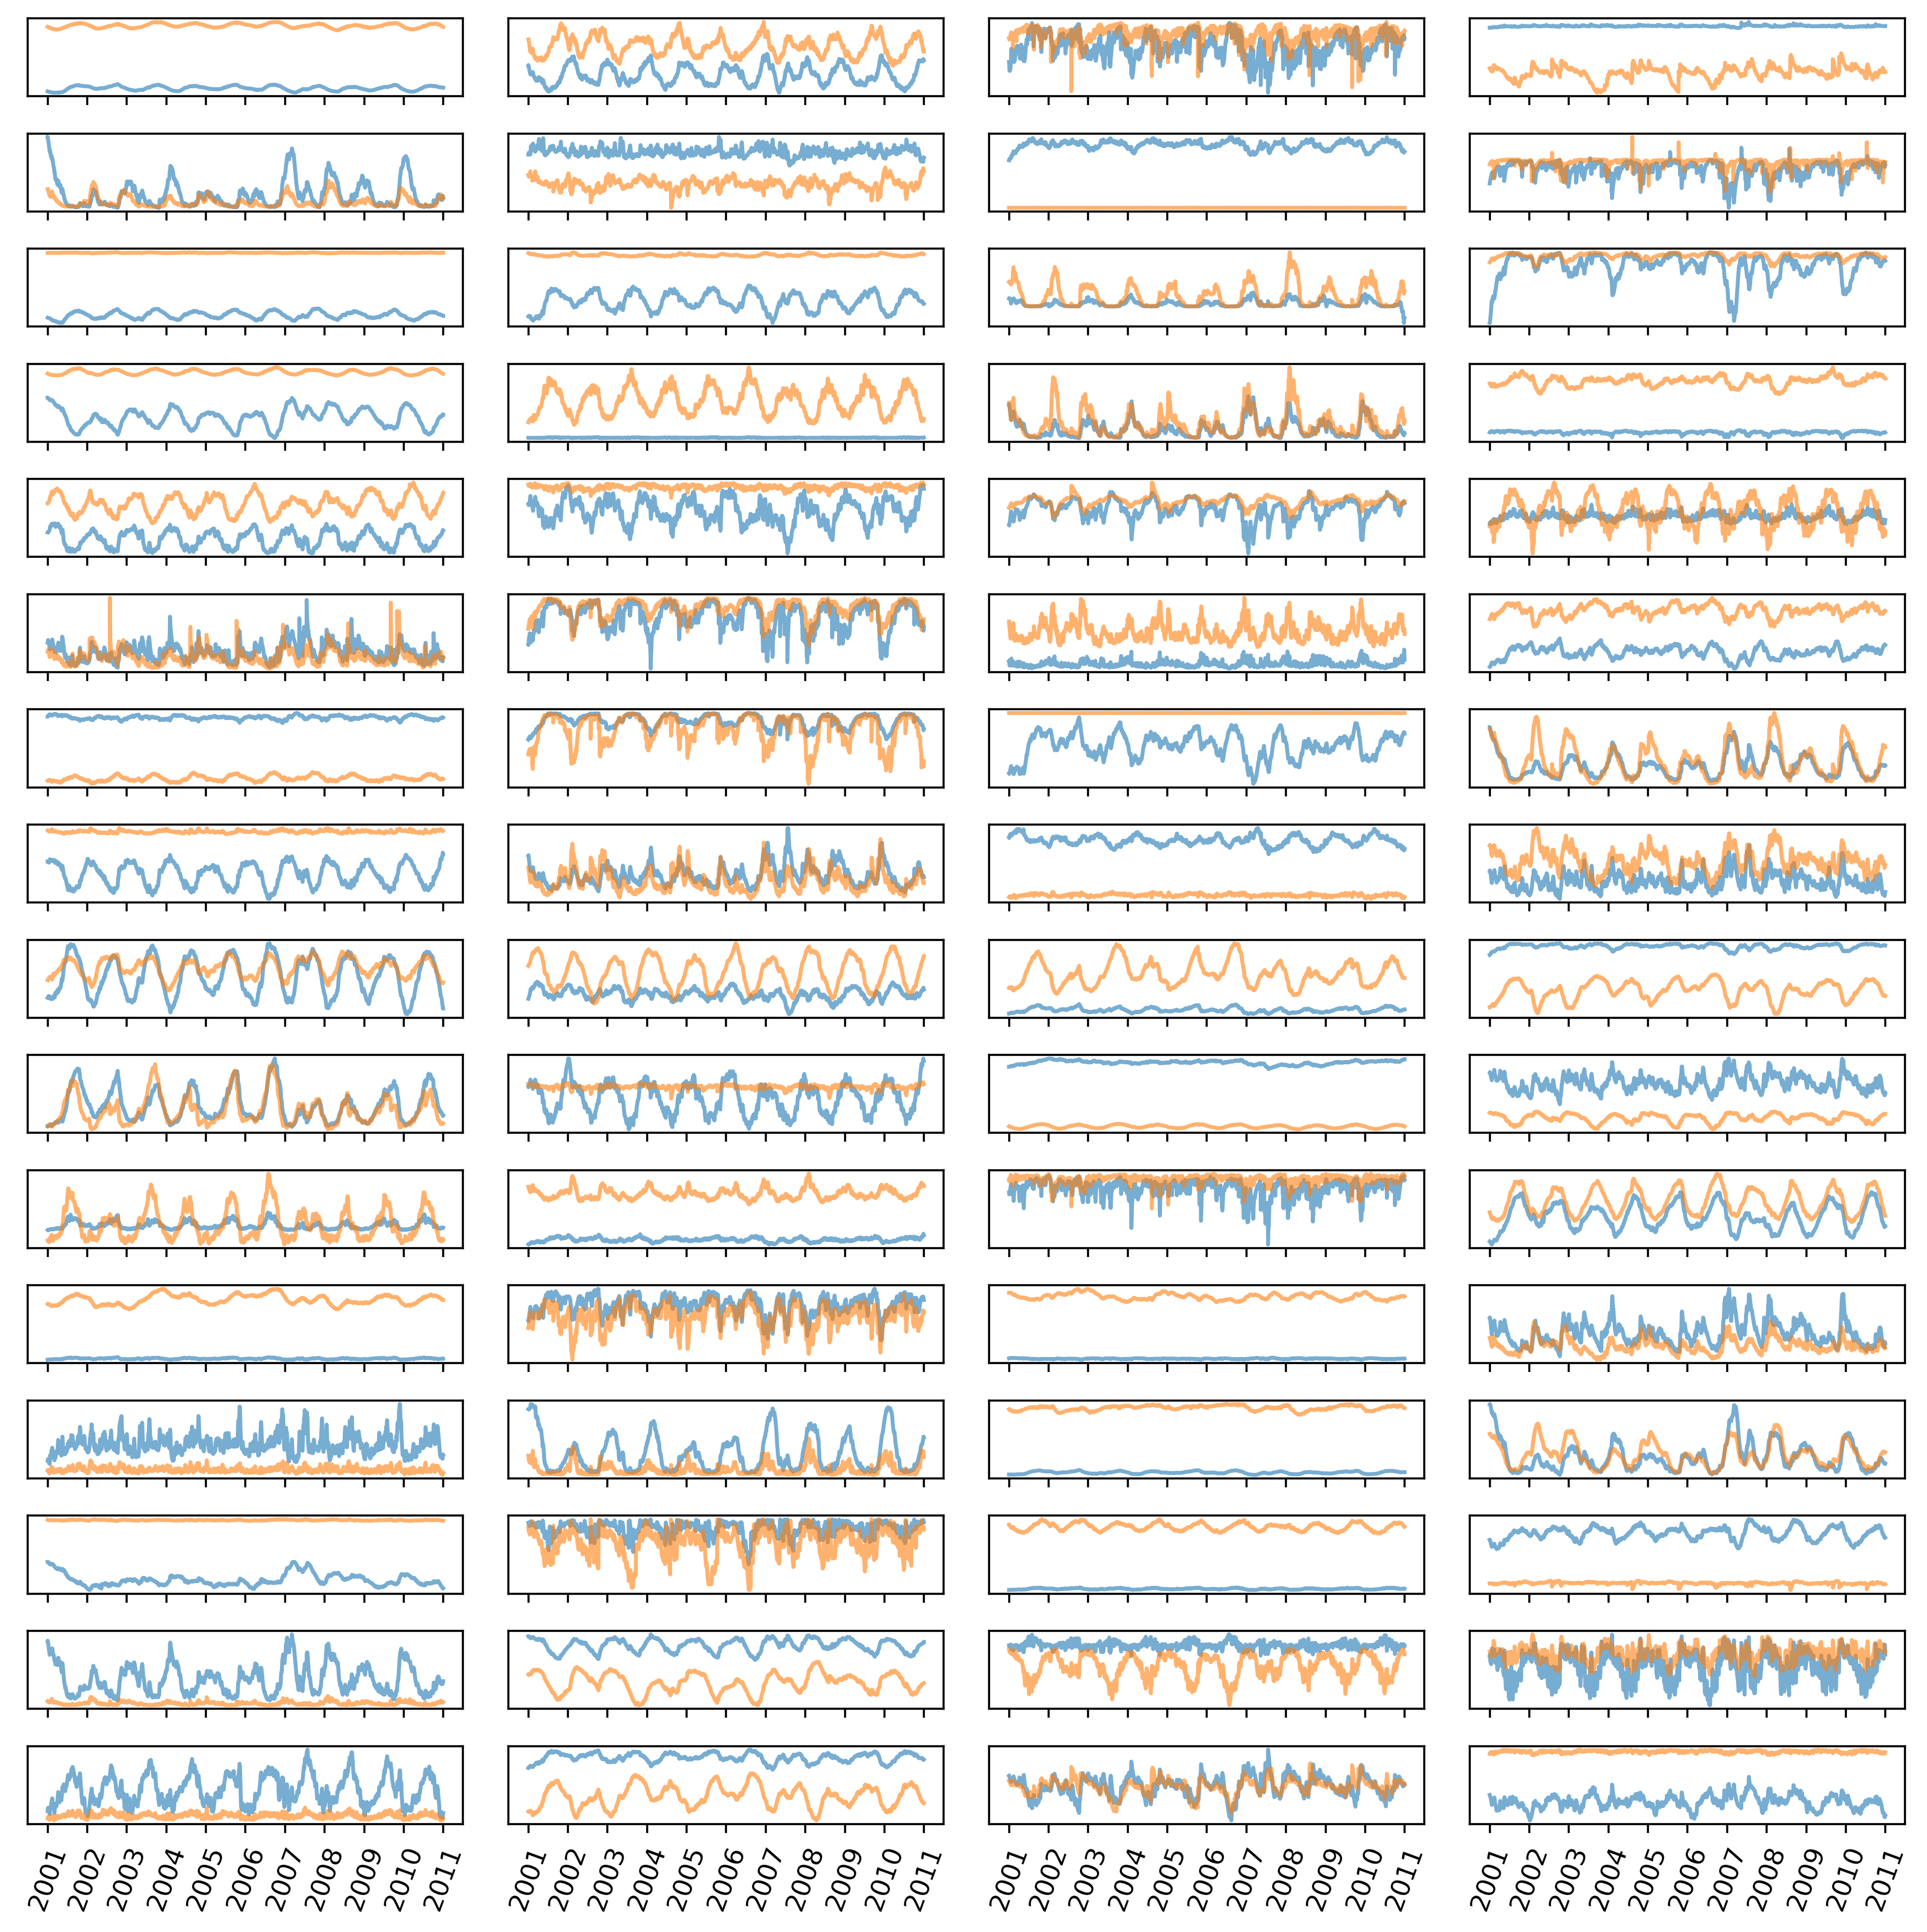

In [142]:
scale = 1.3
N_dims = 64
nrows = int(N_dims / 4)
ncols = 4
TWINX = False

pixels = np.random.choice(norm_cs_data.station_id.values, 2)
pixels = ["54018", "15021"]

with plt.rc_context({"figure.dpi": 400}):
    f, axs = plt.subplots(nrows, ncols, figsize=(2*scale*ncols, 0.5*scale*nrows), tight_layout=True, sharex=True)

    

    for ix in range(64):
        ax = axs[np.unravel_index(ix, (nrows, ncols))]
        for data_ix, pixel in enumerate(pixels):
            data = norm_cs_data.isel(dimension=ix). sel(station_id=pixel).to_dataframe()
            if (data_ix == 1) & (TWINX):
                ax2 = ax.twinx()
                ax2.plot(data.index, data["c_n"], alpha=0.6, color="C1")
                ax2.set_yticklabels([])
                ax2.set_yticks([])
            else:
                ax.plot(data.index, data["c_n"], alpha=0.6)
#         ax.set_xticklabels([])
#         ax.set_xticks([])

        ax.set_yticklabels([])
        ax.set_yticks([])
#         ax.set_title(f"Dimension {ix}")

        ax.tick_params(axis='x', labelrotation=70)


# Principal components
[Review Paper Royal Society](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202#d3e345)

In [ ]:
from eofs.xarray import Eof

In [ ]:
data_array = norm_cs_data["c_n"].transpose("date", "dimension", "station_id")
weights = np.ones(shape=norm_cs_data["station_id"].size)

solver = Eof(data_array, weights)
solver
print(dir(solver))

In [ ]:
data_array

In [ ]:
pcs = solver.pcs(pcscaling=0)
total_var = pcs.mode.var(dim="mode")

n_modes = len(pcs.mode.values)
modes = np.arange(3)
vars_ = solver.varianceFraction()[:len(modes)]
f, axs = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)
ax = axs
for ix, mode in enumerate(modes):
#     var = np.var(pcs.sel(mode=mode))
#     prop_var = float(var) / float(total_var)
    var = vars_[ix]
    pcs.sel(mode=mode).plot(ax=ax, label=f"{float(var):.2f}")

plt.legend()

In [ ]:
# eofs = solver.eofs(neofs=3, eofscaling=1)
# im = plt.matshow(eofs.sel(mode=0).T)
# plt.colorbar()
# im = plt.matshow(eofs.sel(mode=1).T)
# plt.colorbar()
# im = plt.matshow(eofs.sel(mode=2).T)
# plt.colorbar()

In [ ]:
plt.bar(data_array.date.values[:10], solver.varianceFraction()[:10])
plt.xticks(rotation=70);

In [ ]:
solver.eofs(1).isel(station_id=0)

In [ ]:
plt.plot(solver.varianceFraction())

In [ ]:
print(dir(solver))

# Sklearn

In [ ]:
from sklearn.decomposition import PCA
?PCA

In [ ]:
data_array = norm_cs_data["c_n"].transpose()
data_array.coords

In [ ]:
pca = PCA(n_components=3)
print(dir(pca))

In [ ]:
X.shape

In [ ]:
X = data_array.isel(station_id=slice(0, 10))
pca.fit(X)

In [ ]:
y = pca.transform(X)
f, axs = plt.subplots(3, 1, figsize=(12, 2*3))
ax = axs[0]
ax.plot(y[:, 0])
ax.plot(y[:, 1])
ax.plot(y[:, 2])

In [ ]:
# cov = pca.get_covariance()
# f, ax = plt.subplots(figsize=(12, 12))
# im = plt.imshow(cov, vmin=0, vmax=0.5)
# plt.colorbar(im)

# Create the cell states

In [ ]:
from scripts.cell_state.utils import (
    read_basin_list, 
    get_train_test_cell_states, 
    normalize_and_convert_dimension_to_variable_for_cell_state_data, 
    create_train_test_default_dict_for_all_target_vars, 
    train_and_evaluate_models
)

In [ ]:
TARGET = "ERA5"
PER_BASIN = False

## Get training/test dataset

In [ ]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

out_of_sample = not all(np.isin(test_sids, train_sids))
print(f"Out of Sample: {not all(np.isin(test_sids, train_sids))}")

## Probe the basins

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

train_cn, test_cn = get_train_test_cell_states(run_dir, cfg)

# PCA analysis
- [Np.einsum](https://www.youtube.com/watch?v=SOaYrnQtd9g)

In [ ]:
# normalize the vector by space-time mean
M = train_cn.where(~train_cn.isnull(), drop=True)
M = M - M.mean(dim=["date", "station_id"])

# 
M = M.transpose("date", "dimension", "station_id")["c_n"]
M_np = M.values

In [ ]:
# time, variable, space
M_np = np.random.random((100, 64, 50))

np.matmul(M_np, M_np.transpose(0, 2, 1)).shape
np.einsum("tvs,tws->tvw", M_np, M_np).shape